# Predicción del abandono (burnout) de empleados en una empresa

### Configuraciones iniciales 

In [ ]:
# Importaciones necesarias para el desarrollo de la practica
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# Constantes usadas durante el desarrollo de la practica
SEED = 100475757 # La semilla es mi NIA 
employees_ava = pd.read_csv("DATA/employee_availabledata.csv")
employees_comp = pd.read_csv("DATA/employee_competition.csv")
numeric_employees_ava = employees_ava.select_dtypes(include=[np.number]) # Seleccion de las columnas numericas

## EDA 

Antes de nada, voy a comenzar con un análisis de la database para entender mejor la estructura que sigue. Se presentan las siguientes acciones:

1. **Visualización de las primeras filas:** Para obtener una idea general de la estructura del dataset.
2. **Tipos de datos por columna:** Para identificar si las variables son categóricas, numéricas o de otro tipo.
3. **Valores nulos:** Para analizar la cantidad de valores faltantes en cada columna.
4. **Columnas con valores únicos:** Para detectar variables que tienen un solo valor en todo el conjunto de datos, lo que puede indicar redundancia.



In [51]:
# Mostrar las primeras filas del DataFrame
print("Primeras filas:")
display(employees_ava.head())

# Mostrar los tipos de datos de cada columna
print("\nTIPOS DE DATOS:")
print(employees_ava.dtypes)

# Contar los valores nulos en cada columna y mostrarlos
print("\nVALORES NULOS POR COLUMNA:")
display(employees_ava.isnull().sum())

# Encontrar columnas que solo tienen un valor único y mostrarlas
unique_columns = employees_ava.columns[employees_ava.nunique() == 1].tolist()
print("\nColumnas con valores únicos:")
print(unique_columns)

employees_ava.info() 

Primeras filas:


,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,...,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,6.711397,17,2,3,3.0,3.0,4.0,45,Non-Travel,Sales,...,Y,15,8,0,10.0,3,8,5,7,No
1,6.433872,13,3,3,3.0,3.0,3.0,30,Travel_Rarely,Research & Development,...,Y,18,8,1,10.0,3,7,1,7,No
2,8.590515,15,3,3,4.0,3.0,3.0,43,Travel_Frequently,Sales,...,Y,11,8,1,10.0,5,8,4,7,No
3,6.888548,21,3,4,4.0,3.0,3.0,26,Travel_Rarely,Research & Development,...,Y,20,8,0,5.0,3,4,0,0,No
4,6.308825,11,3,3,2.0,1.0,2.0,42,Travel_Rarely,Research & Development,...,Y,11,8,0,10.0,2,0,0,0,No



TIPOS DE DATOS:
hrs                        float64
absences                     int64
JobInvolvement               int64
PerformanceRating            int64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                          int64
BusinessTravel              object
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeID                   int64
Gender                      object
JobLevel                     int64
JobRole                     object
MaritalStatus               object
MonthlyIncome                int64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike            int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany               int64
Yea

hrs                         0
absences                    0
JobInvolvement              0
PerformanceRating           0
EnvironmentSatisfaction    18
JobSatisfaction            14
WorkLifeBalance            20
Age                         0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         10
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
Attrition                   0
dtype: int64


Columnas con valores únicos:
['EmployeeCount', 'Over18', 'StandardHours']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      2940 non-null   float64
 1   absences                 2940 non-null   int64  
 2   JobInvolvement           2940 non-null   int64  
 3   PerformanceRating        2940 non-null   int64  
 4   EnvironmentSatisfaction  2922 non-null   float64
 5   JobSatisfaction          2926 non-null   float64
 6   WorkLifeBalance          2920 non-null   float64
 7   Age                      2940 non-null   int64  
 8   BusinessTravel           2940 non-null   object 
 9   Department               2940 non-null   object 
 10  DistanceFromHome         2940 non-null   int64  
 11  Education                2940 non-null   int64  
 12  EducationField           2940 non-null   object 
 13  Emp

Como se puede observar, existen varias columnas de la base de datos con valores nulos y algunas con un valor único en todas las filas, las cuales podrian no aportar información relevante. Además, las variables categóricas necesitarán ser codificadas en formato numérico para su correcto procesamiento. 

### Análisis de la Variable Objetivo "Attrition"

También voy a realizar un análisis de la variable objetivo "Attrition" para entender mejor su distribución en el conjunto de datos. La variable "Attrition" indica si un empleado ha dejado la empresa (yes) o no (no). Para ello, he querido realizar lo siguiente: 

1. **Contar el número de empleados en cada categoría y calcular el porcentaje correspondiente.**

2. **Mostrar un DataFrame con el conteo y el porcentaje de empleados que han dejado la empresa y los que no.**

3. **Crear un gráfico de barras para visualizar la distribución de "Attrition".**


,Count,Percentage
Attrition,,
No,2466,83.877551
Yes,474,16.122449


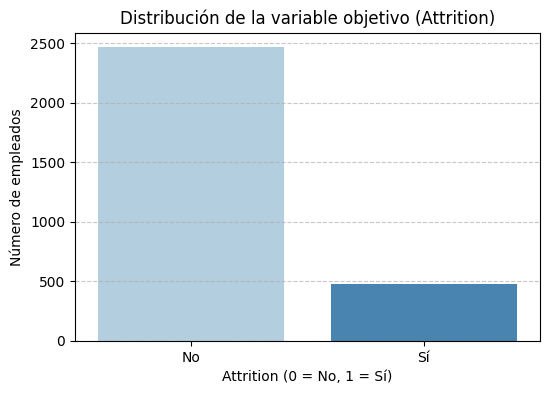

In [52]:
# Análisis de la variable objetivo "Attrition"
attrition_counts = employees_ava["Attrition"].value_counts()
attrition_percentage = employees_ava["Attrition"].value_counts(normalize=True) * 100

# Mostrar los valores y porcentajes en un DataFrame
attrition_summary = pd.DataFrame({"Count": attrition_counts, "Percentage": attrition_percentage})
display(attrition_summary)

# Visualización de la distribución de la variable objetivo
plt.figure(figsize=(6,4))
sns.barplot(x=attrition_counts.index, y=attrition_counts.values, hue=attrition_counts.index, palette="Blues")
plt.title("Distribución de la variable objetivo (Attrition)")
plt.xlabel("Attrition (0 = No, 1 = Sí)")
plt.ylabel("Número de empleados")
plt.xticks([0,1], ["No", "Sí"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Se trata de un problema de clasificación en el que la variable objetivo 'Attrition' presenta un claro desbalance, con un 83.88% de empleados que no han abandonado frente a un 16.12% que sí. Este desequilibrio podría influir en el rendimiento del modelo, favoreciendo la predicción de la clase mayoritaria y dificultando la detección de los casos de abandono.

Antes de continuar, voy a realizar una limpieza de variables, eliminando las columnas con valores únicos (Over18, EmployeeCount y StandardHours) y las que no aportan información relevante (EmployeeID). 

In [53]:
# Eliminación de las columnas con valores únicos
employees_ava = employees_ava.drop(columns=unique_columns)

# Eliminación de la columna "EmployeeID"
employees_ava = employees_ava.drop(columns="EmployeeID")

# Nueva asignación de las columnas numéricas
numeric_employees_ava = employees_ava.select_dtypes(include=[np.number])

print("Columnas eliminadas: ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeID']")
print("Columnas restantes:", employees_ava.shape[1])

Columnas eliminadas: ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeID']
Columnas restantes: 27


### Búsqueda de valores Atípicos 

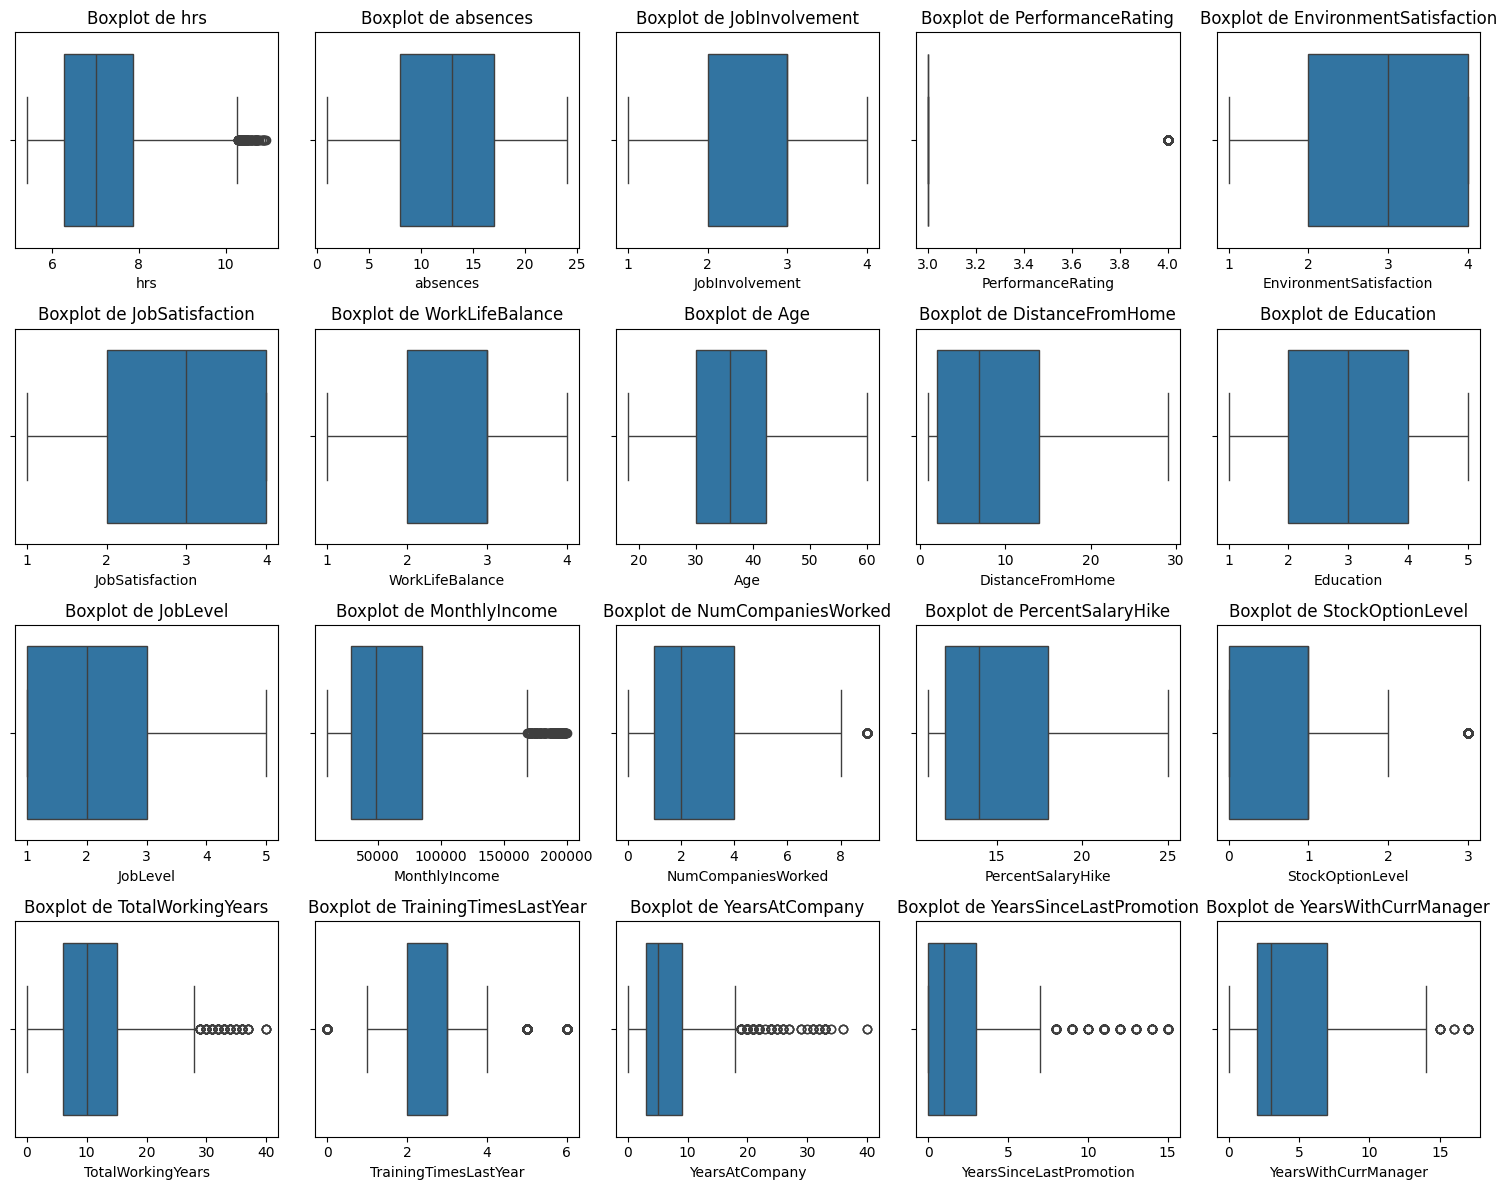

In [54]:
# Búsqueda de valores atípicos en las columnas numéricas
num_plots = len(numeric_employees_ava.columns)
num_rows = -(-num_plots // 5)  

fig, axs = plt.subplots(num_rows, 5, figsize=(15, 3*num_rows))

axs = axs.flatten() # Aplanar el array de ejes para facilitar el acceso

for i, column in enumerate(numeric_employees_ava.columns):
    sns.boxplot(x=numeric_employees_ava[column], ax=axs[i])
    axs[i].set_title(f"Boxplot de {column}")

# Ocultar ejes sobrantes
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

Como se puede observar, hay variables que cuentan con valores atípicos, ya sea porque se encuentran muy por encima o por debajo de los valores típicos como en el caso de **['hrs', 'MonthlyIncome', 'TotalWorkingYears',   'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']** o porque existe una gran mayoría de valores en un mismo número, lo que hace que el resto de valores sean considerados atípicos, aunque la diferencia no sea tan grande como en el caso anterior. Es el caso de **['PerformanceRating', 'NumCompaniesWorked', 'StockOptionLevel']**.

### Matriz de correlación general 

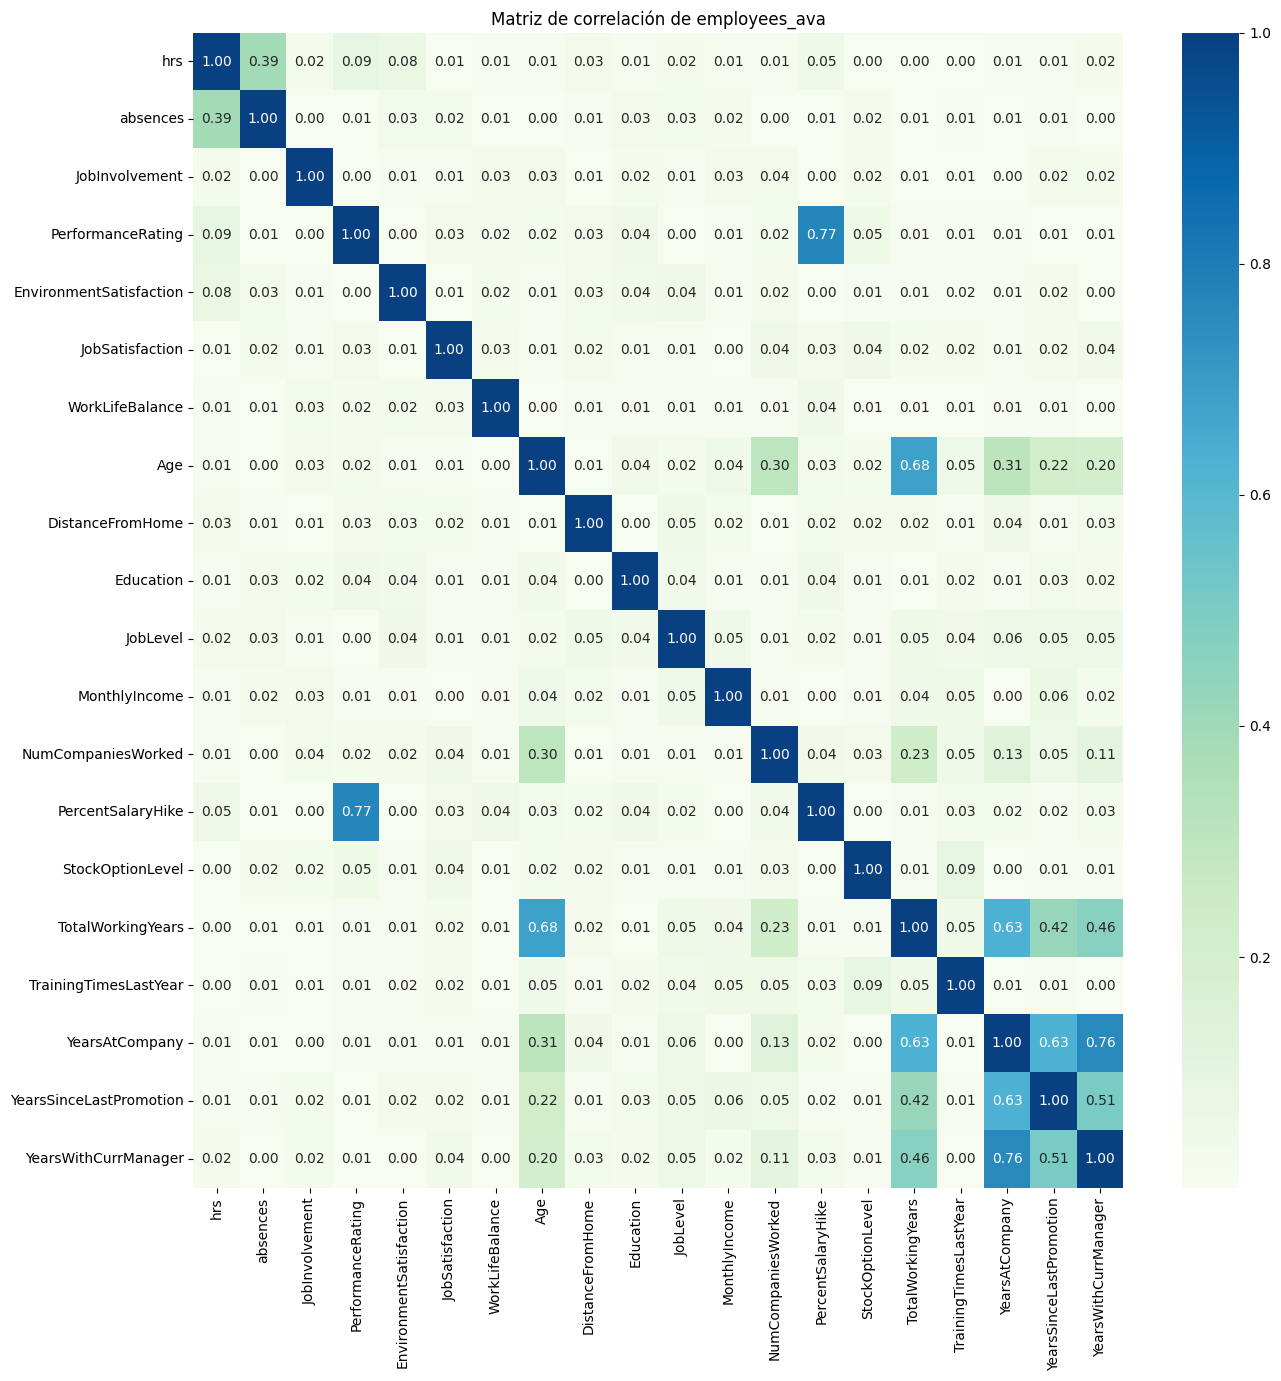

In [55]:
# Calcular la matriz de correlación de variables numéricas
correlation = numeric_employees_ava.corr()

# Poner correlaciones en valor absoluto
correlation = correlation.abs()

# Mostrar la matriz de correlación
plt.figure(figsize=(15, 15))
sns.heatmap(correlation, annot=True, cmap="GnBu", fmt=".2f")
plt.title("Matriz de correlación de employees_ava")
plt.show()

Como se puede observar, no existe una correlación muy fuerte entre las variables independientes, lo que puede indicar que aportan información relevante para el modelo. La correlación más alta se encuentra entre **'PerformanceRating'** y **'PercentSalaryHike'** con un valor de 0.77, lo que podría indicar cierta multicolinealidad entre estas variables. Además, solo se está analizando la correlación de variables numéricas, por lo tanto, no veo posible reducir la dimensionalidad del problema y voy a continuar sin eliminar ninguna variable. 

## Métodos de Evaluación
### Evaluación Outer e Inner

#### Pipelines

Antes de continuar, voy a realizar el preprocesamiento y optimización de los datos, transformando las variables categóricas a numéricas a través de **OneHotEncoding**. En el caso de las columnas numéricas en las que hay valores nulos, voy a imputar la mediana de cada columna, ya que es robusta frente a valores atípicos (outliers), lo que significa que si la variable tiene datos extremos, la mediana no se verá afectada tanto como la media. Gracias a esto la imputación no distorsiona la distribución original de la variable.

In [56]:
# Convertir la variable objetivo 'Attrition' a binaria: 1 para "Yes", 0 para "No"
employees_ava['Attrition'] = employees_ava['Attrition'].map({'Yes': 1, 'No': 0})

# Separar las features y la variable objetivo
X = employees_ava.drop(columns=['Attrition'])
y = employees_ava['Attrition']

# Identificar columnas categóricas y numéricas
categorical_columns = X.select_dtypes(include=["object"]).columns.tolist()
numeric_columns = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Pipeline para transformar las variables categóricas
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputa valores nulos con la moda
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Transforma variables categóricas a numéricas
])

# Pipeline para transformar las variables numéricas
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputa valores nulos con la mediana
    ('scaler', RobustScaler())                      # Escala las variables numéricas
])

# Combinar ambos pipelines en un ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_columns),
    ('cat', categorical_pipeline, categorical_columns)
])

# Aplicar el preprocesamiento a las features
X_preprocessed = preprocessor.fit_transform(X)

print("Forma de los datos preprocesados:", X_preprocessed.shape)

Forma de los datos preprocesados: (2940, 46)


Voy a comenzar dividiendo el conjunto de datos en dos partes: un conjunto de entrenamiento (2/3 de los datos) y un conjunto de prueba (1/3 de los datos) escogidos de forma aleatoria usando como semilla mi NIA. El conjunto de entrenamiento se utilizará para ajustar el modelo, mientras que el conjunto de prueba se utilizará para evaluar su rendimiento. Además, haré uso de las métricas mencionadas en el enunciado para crear un modelo básico y evaluarlo.

In [57]:
# Dividir en 2/3 para entrenamiento y 1/3 para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=SEED, stratify=y)

# Preprocesar los conjuntos de entrenamiento y prueba
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Ver el tamaño de los conjuntos de entrenamiento y prueba
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} filas")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} filas")


Tamaño del conjunto de entrenamiento: 1960 filas
Tamaño del conjunto de prueba: 980 filas


#### Modelo Dummy 

Voy a empezar crerando un modelo Dummy para tener una referencia de la que partir. Este modelo es un clasificador que predice la clase mayoritaria en todo momento, por lo que no tiene en cuenta las características de los datos.

In [58]:
# Crear y entrenar el modelo Dummy (predice siempre la clase mayoritaria)
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=SEED)
dummy_clf.fit(X_train, y_train)

# Predicciones en el conjunto de prueba con el modelo Dummy
y_pred_dummy = dummy_clf.predict(X_test)

# Métricas para el modelo Dummy
balanced_accuracy_dummy = balanced_accuracy_score(y_test, y_pred_dummy)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)

#### Modelos Básicos: DecisionTreeClassifier y KNN

Ahora, voy a evaluar los modelos básicos de clasificación 'DecisionTreeClassifier' y 'KNeighborsClassifier' utilizando la validación cruzada con 5 folds, que permite dividir los datos de entrenamiento en 5 partes y entrenar el modelo 5 veces, utilizando 4 partes para el entrenamiento y 1 para la validación. De esta forma, se obtiene una estimación más robusta del rendimiento del modelo. Luego, compararé los resultados obtenidos con los resultados del modelo Dummy.

,Balanced Accuracy,Accuracy
Dummy,0.500000,0.838776
Decision Tree,0.809519,0.892857
KNN,0.589966,0.837245


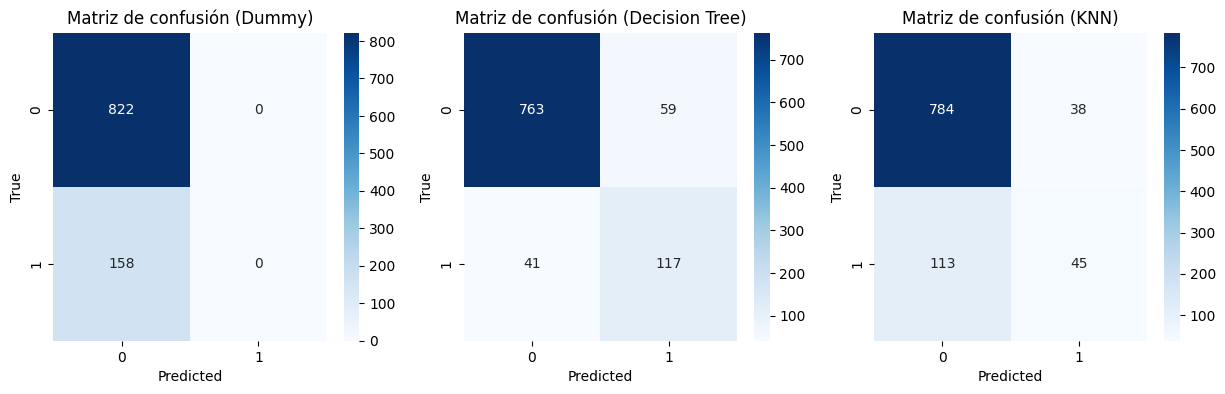

In [59]:
# Lista de modelos a evaluar
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=SEED),
    "KNN": KNeighborsClassifier(),
}

# Evaluar cada modelo en train usando cross-validation (5 folds)
cv_results = {}

# Almacenar los resultados del modelo Dummy
cv_results["Dummy"] = {'Balanced Accuracy': balanced_accuracy_dummy, 'Accuracy': accuracy_dummy}


for model_name, model in models.items():
    # Evaluar con balanced accuracy
    balanced_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='balanced_accuracy')
    balanced_accuracy = balanced_scores.mean()
    
    # Evaluar con accuracy
    accuracy_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    accuracy = accuracy_scores.mean()
    
    # Almacenar los resultados
    cv_results[model_name] = {'Balanced Accuracy': balanced_accuracy, 'Accuracy': accuracy}

# Mostrar los resultados en formato de tabla
cv_results_df = pd.DataFrame(cv_results).T
display(cv_results_df)

# Mostrar matriz de confusión de los tres modelos (Dummy, Decision Tree, KNN)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, model_name in enumerate(["Dummy", "Decision Tree", "KNN"]):
    if model_name == "Dummy":
        conf_matrix = confusion_matrix(y_test, y_pred_dummy)
    else:
        model = models[model_name]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        conf_matrix = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[i])
    axs[i].set_title(f"Matriz de confusión ({model_name})")
    axs[i].set_xlabel("Predicted")
    axs[i].set_ylabel("True")

Como se puede observar, en el modelo Dummy hay 822 verdaderos negativos y 158 falsos negativos, sin ningún verdadero positivo. El modelo identifica correctamente a todos los empleados que no abandonan (TNR = 1.0) y falla completamente en detectar a aquellos que sí abandonan (TPR = 0.0). Su balanced_accuracy de 0.5 (la media de (TNR + TPR)) indica que este modelo no es mejor que una clasificación aleatoria y sus métricas indican claramente que no aporta información útil para la detección de la variable objetivo 'Attrition'. Por lo tanto, cumple con el objetivo de ser un modelo dummy.

Los modelos DecisionTreeClassifier y KNeighborsClassifier presentan un rendimiento superior al modelo Dummy en todas las métricas evaluadas. Basándome en la métrica principal para la evaluación de los modelos (balanced_accuracy), el modelo DecisionTreeClassifier obtiene un valor de 0.8, mientras que el modelo KNeighborsClassifier obtiene un valor de 0.59. Por lo tanto, el modelo básico DecisionTreeClassifier es el que mejor se ajusta a los datos de entrenamiento.

## Métodos de escalado e imputación con KNN

,Escalado,Imputación,Mean Balanced Accuracy,Training Time
0,MinMaxScaler,mean,0.601280,0.250739
1,MinMaxScaler,median,0.601280,0.159182
2,StandardScaler,mean,0.589577,0.124253
3,StandardScaler,median,0.589577,0.151908
4,RobustScaler,mean,0.581464,0.216280
5,RobustScaler,median,0.581464,0.285347


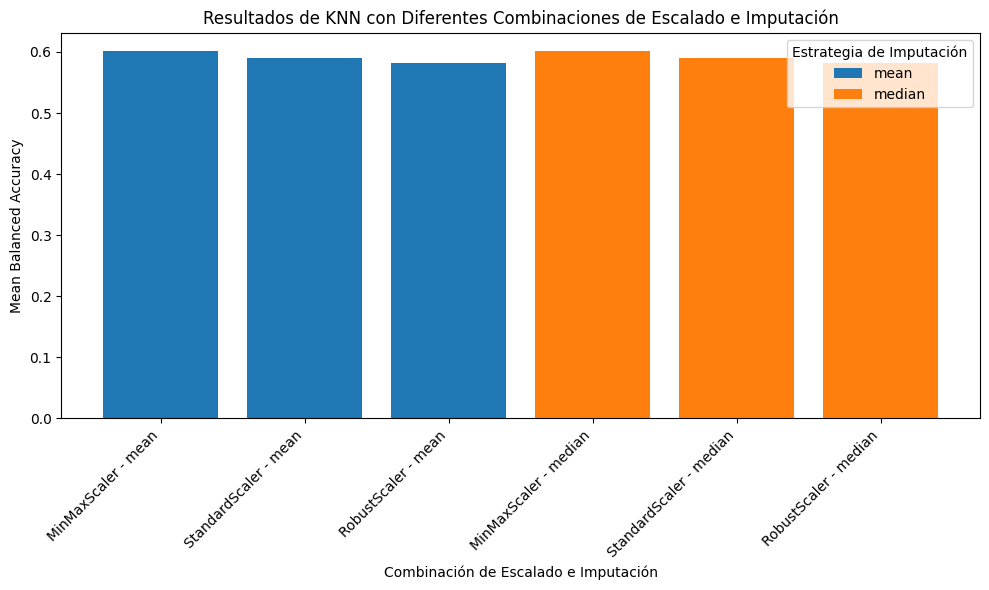

In [60]:
# Lista de métodos de escalado y de imputación
scalers = [MinMaxScaler(), StandardScaler(), RobustScaler()]
imputers = [SimpleImputer(strategy='mean'), SimpleImputer(strategy='median')]

# Creando el pipeline para KNN con diferentes combinaciones de escalado e imputación
results_knn = []

for scaler in scalers:
    for imputer in imputers:
        # Crear el pipeline para KNN
        pipeline_knn = Pipeline([
            ('imputer', imputer),
            ('scaler', scaler),
            ('knn', KNeighborsClassifier())
        ])
        
        # Medir el tiempo de entrenamiento y evaluarlo
        start_time = time.time()
        scores = cross_val_score(pipeline_knn, X_train, y_train, cv=5, scoring='balanced_accuracy')
        end_time = time.time()

        # Guardar resultados
        results_knn.append({
            'Escalado': scaler.__class__.__name__,
            'Imputación': imputer.strategy,
            'Mean Balanced Accuracy': scores.mean(),
            'Training Time': end_time - start_time
        })

# Crear un DataFrame con los resultados
results_knn_df = pd.DataFrame(results_knn)
display(results_knn_df)

# Crear un gráfico de barras para la precisión balanceada media
plt.figure(figsize=(10, 6))
for strategy in results_knn_df['Imputación'].unique():
    subset = results_knn_df[results_knn_df['Imputación'] == strategy]
    plt.bar(subset['Escalado'] + ' - ' + strategy, subset['Mean Balanced Accuracy'], label=strategy)

plt.xlabel('Combinación de Escalado e Imputación')
plt.ylabel('Mean Balanced Accuracy')
plt.title('Resultados de KNN con Diferentes Combinaciones de Escalado e Imputación')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Estrategia de Imputación')
plt.tight_layout()
plt.show()

Como se puede observar, la combinación óptima para este problema es MinMaxScaler junto con imputación por media, ya que alcanza la mayor balanced accuracy (0.6013) manteniendo un coste computacional bajo (0.11 segundos de entrenamiento) lo que indica una mejor capacidad para clasificar correctamente tanto a empleados que abandonan como a los que no. 

La ausencia de diferencias significativas entre la imputación por media y por mediana se debe a que las variables numéricas del conjunto de datos carecen de outliers extremos. Esto también explica por qué el uso de RobustScaler, diseñado específicamente para manejar outliers, no ha aportado mejoras en el rendimiento en este caso.

### Evaluacion de los modelos con los parámetros por defecto


In [ ]:
# KNN con hiperparámetros por omisión

pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())  # hiperparámetros por defecto
])

start_knn = time.time()
pipeline_knn.fit(X_train, y_train)
end_knn = time.time()

# Predecir los valores del test 
y_pred_knn = pipeline_knn.predict(X_test)

# Métricas
bal_acc_knn = balanced_accuracy_score(y_test, y_pred_knn)
acc_knn = accuracy_score(y_test, y_pred_knn)

# --------------------------------------------------------------------------------------------------------------------

# Árbol de decisión con hiperparámetros por omisión

pipeline_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # solo imputación, sin escalado
    ('tree', DecisionTreeClassifier(random_state=SEED))  # por defecto
])

# Entrenamiento
start_tree = time.time()
pipeline_tree.fit(X_train, y_train)
end_tree = time.time()

y_pred_tree = pipeline_tree.predict(X_test)

# Métricas
bal_acc_tree = balanced_accuracy_score(y_test, y_pred_tree)
acc_tree = accuracy_score(y_test, y_pred_tree)

# --------------------------------------------------------------------------------------------------------------------

# RandomForest con hiperparámetros por omisión

pipeline_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # solo imputación, sin escalado
    ('rf', RandomForestClassifier(random_state=SEED))
])

# Entrenamiento
start_rf = time.time()
pipeline_rf.fit(X_train, y_train)
end_rf = time.time()

# Predicciones
y_pred_rf = pipeline_rf.predict(X_test)

# Métricas
bal_acc_rf = balanced_accuracy_score(y_test, y_pred_rf)
acc_rf = accuracy_score(y_test, y_pred_rf)

# Tiempo de entrenamiento
knn_time = end_knn - start_knn
tree_time = end_tree - start_tree
rf_time = end_rf - start_rf

# ----------------------------------------------------------------------------------------------------

# Crear un DataFrame con los resultados

results = pd.DataFrame({
    "Balanced Accuracy": [bal_acc_knn, bal_acc_tree, bal_acc_rf],
    "Accuracy": [acc_knn, acc_tree, acc_rf],
    "Training Time": [knn_time, tree_time, rf_time]
}, index=["KNN", "Árbol de Decisión", "Random Forest"])

display(results)

,Balanced Accuracy,Accuracy,Training Time
KNN,0.618444,0.831633,0.013459
Árbol de Decisión,0.834365,0.897959,0.046185
Random Forest,0.836783,0.944898,0.691098


### Evaluacion de los modelos con los hiperparametros ajustados
#### KNN

In [62]:
# Pipeline para preprocesar e incluir el modelo
pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

# Espacio de búsqueda de hiperparámetros
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

# GridSearchCV
grid_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Medir tiempo de entrenamiento
start_time = time.time()
grid_knn.fit(X_train, y_train)
end_time = time.time()

# Resultados
best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

# Métricas
bal_knn_hpo = balanced_accuracy_score(y_test, y_pred_knn)
acc_knn_hpo = accuracy_score(y_test, y_pred_knn)

# Tiempo de entrenamiento
knn_time_hpo = end_time - start_time

print("KNN optimizado")
print(f"Mejores hiperparámetros: {grid_knn.best_params_}")
print(f"Balanced Accuracy: {bal_knn_hpo:.4f}")
print(f"Accuracy: {acc_knn_hpo:.4f}")
print(f"Tiempo de entrenamiento con HPO: {knn_time_hpo:.4f} segundos")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
KNN optimizado
Mejores hiperparámetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Balanced Accuracy: 0.8798
Accuracy: 0.9398
Tiempo de entrenamiento con HPO: 5.4762 segundos


#### DecisionTreeClassifier

In [63]:
# Pipeline: solo imputación (los árboles no necesitan escalado)
pipeline_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('tree', DecisionTreeClassifier(random_state=SEED))
])

# Espacio de búsqueda de hiperparámetros
param_grid_tree = {
    'tree__max_depth': [5, 10, 15, 20, None],
    'tree__min_samples_split': [2, 5, 10],
    'tree__min_samples_leaf': [1, 2, 4]
}

# GridSearchCV
grid_tree = GridSearchCV(
    estimator=pipeline_tree,
    param_grid=param_grid_tree,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Medir tiempo de entrenamiento
start_time = time.time()
grid_tree.fit(X_train, y_train)
end_time = time.time()

# Resultados
best_tree = grid_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test)

# Métricas
bal_tree_hpo = balanced_accuracy_score(y_test, y_pred_tree)
acc_tree_hpo = accuracy_score(y_test, y_pred_tree)

# Tiempo de entrenamiento
tree_time_hpo = end_time - start_time

print("Árbol de decisión optimizado")
print(f"Mejores hiperparámetros: {grid_tree.best_params_}")
print(f"Balanced Accuracy (test): {bal_tree_hpo:.4f}")
print(f"Accuracy (test): {acc_tree_hpo:.4f}")
print(f"Tiempo de entrenamiento con HPO: {tree_time_hpo:.4f} segundos")


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Árbol de decisión optimizado
Mejores hiperparámetros: {'tree__max_depth': 20, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}
Balanced Accuracy (test): 0.8344
Accuracy (test): 0.8980
Tiempo de entrenamiento con HPO: 2.2333 segundos


#### RandomForestClassifier

In [64]:
# Pipeline con imputación y Random Forest
pipeline_rf_hpo = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('rf', RandomForestClassifier(random_state=SEED))
])

# Espacio de búsqueda
param_grid_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

# GridSearchCV
grid_rf = GridSearchCV(
    estimator=pipeline_rf_hpo,
    param_grid=param_grid_rf,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entrenamiento
start_time = time.time()
grid_rf.fit(X_train, y_train)
end_time = time.time()

# Mejores resultados
best_rf = grid_rf.best_estimator_
y_pred_rf_hpo = best_rf.predict(X_test)

# Métricas
bal_rf_hpo = balanced_accuracy_score(y_test, y_pred_rf_hpo)
acc_rf_hpo = accuracy_score(y_test, y_pred_rf_hpo)

# Tiempo de entrenamiento
rf_time_hpo = end_time - start_time

print("Random Forest optimizado")
print(f"Mejores hiperparámetros: {grid_rf.best_params_}")
print(f"Balanced Accuracy (test): {bal_rf_hpo:.4f}")
print(f"Accuracy (test): {acc_rf_hpo:.4f}")
print(f"Tiempo de entrenamiento con HPO: {rf_time_hpo:.4f} segundos")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Random Forest optimizado
Mejores hiperparámetros: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Balanced Accuracy (test): 0.8494
Accuracy (test): 0.9490
Tiempo de entrenamiento con HPO: 30.2544 segundos


Habiendo obtenido los resultados de los modelos con los hiperparametros ajustados, voy a compararlos con los resultados obtenidos con los hiperparametros por defecto para distinguir qué modelo será empleado en la predicción del abandonos de empleados.

### Represenación gráfica de los resultados obtenidos

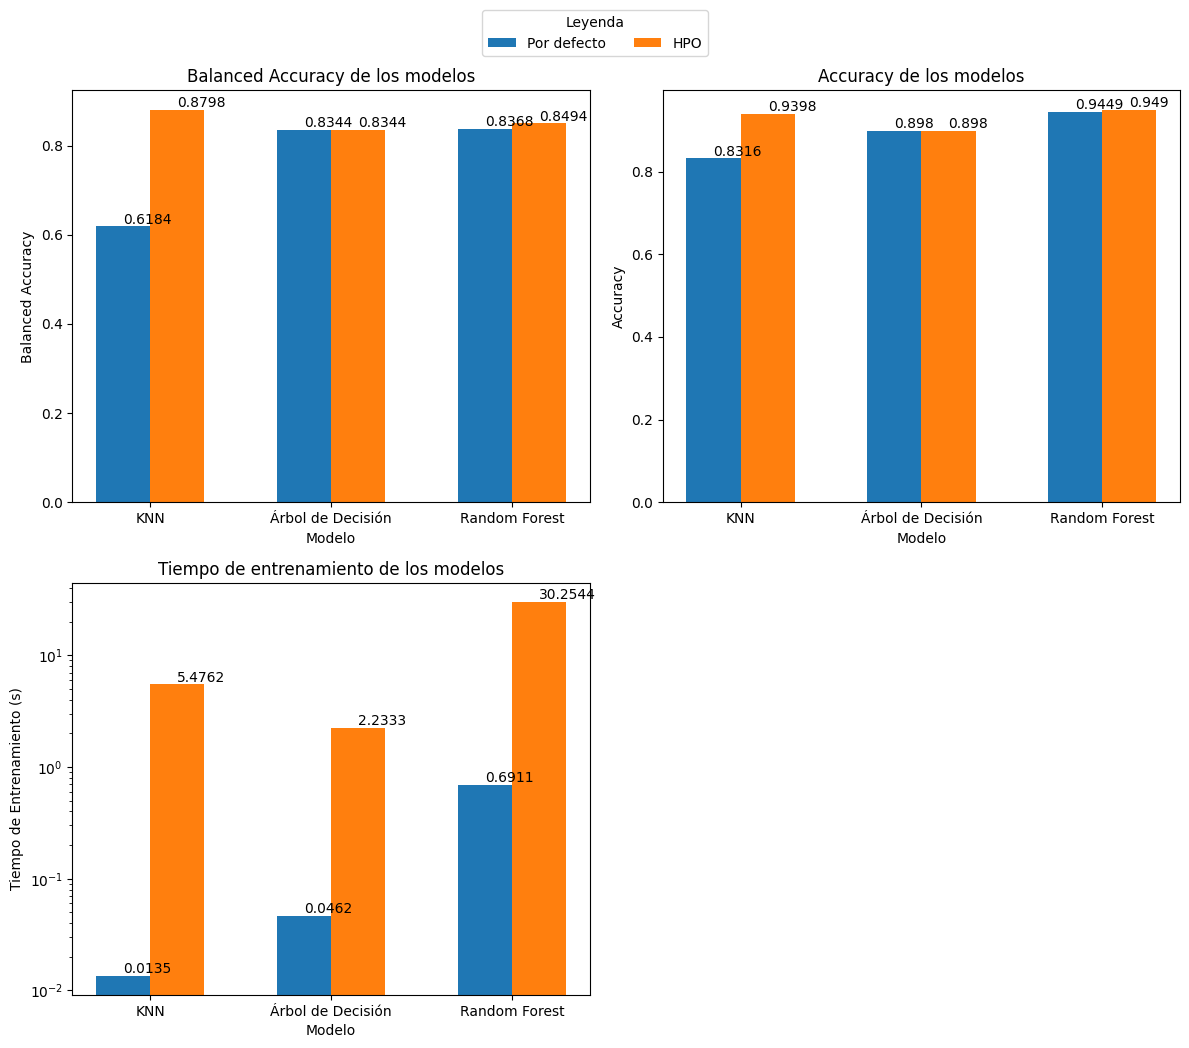

In [ ]:
# Datos para Balanced Accuracy, Accuracy y tiempos de entrenamiento
balanced_accuracy = [bal_acc_knn, bal_acc_tree, bal_acc_rf]  # Antes
balanced_accuracy_hpo = [bal_knn_hpo, bal_tree_hpo, bal_rf_hpo]  # Después de optimización

accuracy = [acc_knn, acc_tree, acc_rf]  # Antes
accuracy_hpo = [acc_knn_hpo, acc_tree_hpo, acc_rf_hpo]  # Después de optimización

tiempos = [knn_time, tree_time, rf_time]  # Antes
tiempos_hpo = [knn_time_hpo, tree_time_hpo, rf_time_hpo]  # Después de HPO

# Modelos
modelos = ['KNN', 'Árbol de Decisión', 'Random Forest']

# Crear una figura con dos gráficos en la primera fila y uno centrado en la segunda fila
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 1]})

# Eliminar el segundo gráfico de la segunda fila para que el gráfico de tiempo ocupe toda la fila
fig.delaxes(axs[1, 1])

# -------------------------------------------------------------------------------------------------------

# Crear el gráfico de Balanced Accuracy
width = 0.30
bar_positions = np.arange(len(modelos))

# Gráfico de Balanced Accuracy
bars1 = axs[0, 0].bar(bar_positions - width/2, balanced_accuracy, width, color='#1f77b4', label='Por defecto')
bars2 = axs[0, 0].bar(bar_positions + width/2, balanced_accuracy_hpo, width, color='#ff7f0e', label='HPO')

# Añadir etiquetas a las barras
for bar in bars1:
    yval = bar.get_height()
    axs[0, 0].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')

for bar in bars2:
    yval = bar.get_height()
    axs[0, 0].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')

axs[0, 0].set_xlabel('Modelo')
axs[0, 0].set_ylabel('Balanced Accuracy')
axs[0, 0].set_title('Balanced Accuracy de los modelos')
axs[0, 0].set_xticks(bar_positions)
axs[0, 0].set_xticklabels(modelos)
axs[0, 0].set_yscale('linear')

# ------------------------------------------------------------------------------------------------------

# Gráfico de Accuracy
bars1 = axs[0, 1].bar(bar_positions - width/2, accuracy, width, color='#1f77b4', label='Por defecto')
bars2 = axs[0, 1].bar(bar_positions + width/2, accuracy_hpo, width, color='#ff7f0e', label='HPO')

# Añadir etiquetas a las barras
for bar in bars1:
    yval = bar.get_height()
    axs[0, 1].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')

for bar in bars2:
    yval = bar.get_height()
    axs[0, 1].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')

axs[0, 1].set_xlabel('Modelo')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_title('Accuracy de los modelos')
axs[0, 1].set_xticks(bar_positions)
axs[0, 1].set_xticklabels(modelos)
axs[0, 1].set_yscale('linear')

# ------------------------------------------------------------------------------------------------------

# Gráfico de Tiempo de Entrenamiento
bars1 = axs[1, 0].bar(bar_positions - width/2, tiempos, width, color='#1f77b4', label='Por defecto')
bars2 = axs[1, 0].bar(bar_positions + width/2, tiempos_hpo, width, color='#ff7f0e', label='HPO')

# Añadir etiquetas a las barras
for bar in bars1:
    yval = bar.get_height()
    axs[1, 0].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')

for bar in bars2:
    yval = bar.get_height()
    axs[1, 0].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')

axs[1, 0].set_xlabel('Modelo')
axs[1, 0].set_ylabel('Tiempo de Entrenamiento (s)')
axs[1, 0].set_title('Tiempo de entrenamiento de los modelos')
axs[1, 0].set_xticks(bar_positions)
axs[1, 0].set_xticklabels(modelos)
axs[1, 0].set_yscale('log')

# Añadir una leyenda compartida para todos los gráficos
fig.legend(['Por defecto', 'HPO'], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, title="Leyenda")
plt.tight_layout()
plt.show()

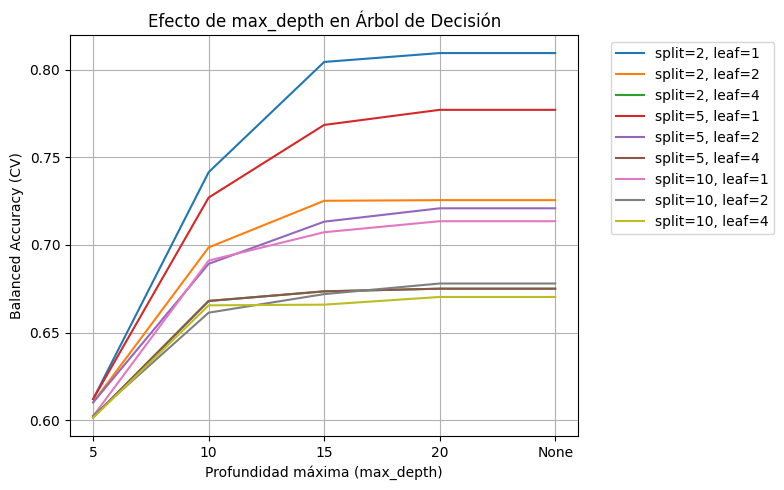

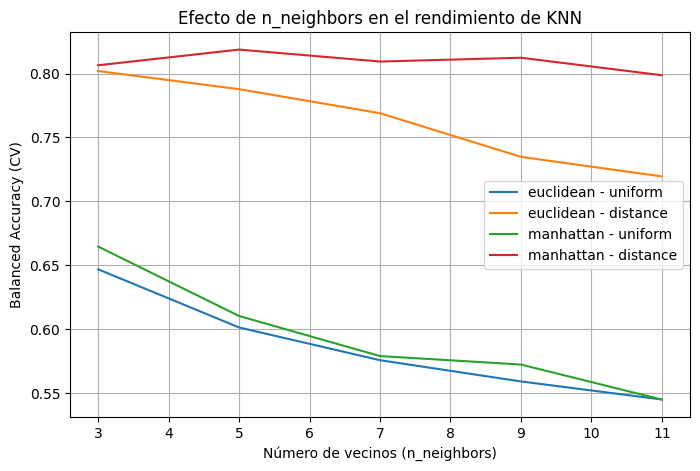

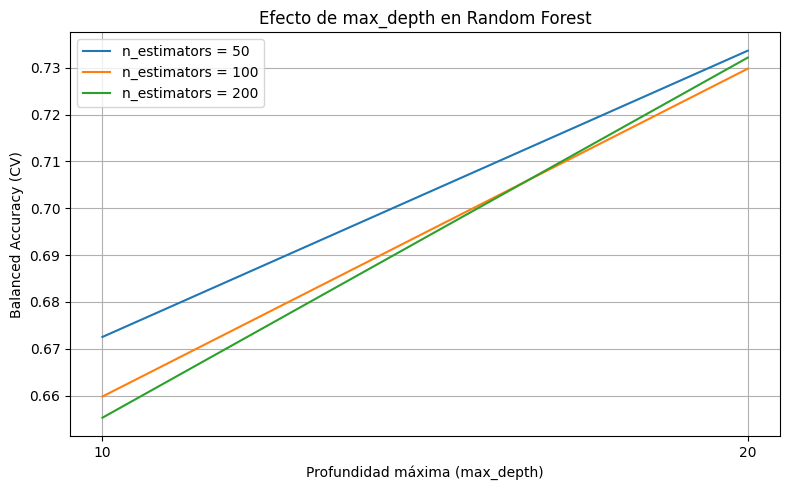

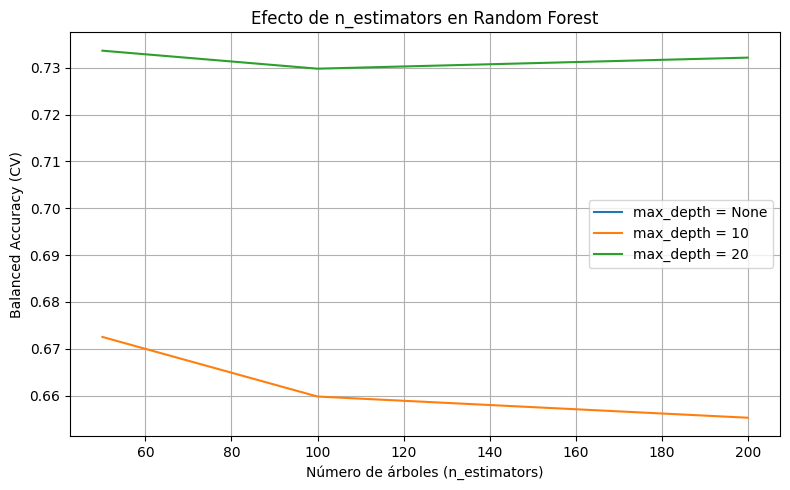

In [69]:
# Convertir los resultados de GridSearchCV para Árbol de Decisión a DataFrame
tree_results = pd.DataFrame(grid_tree.cv_results_)

# Crear el gráfico para 'max_depth'
plt.figure(figsize=(8, 5))
for split in [2, 5, 10]:
    subset = tree_results[tree_results['param_tree__min_samples_split'] == split]
    for leaf in [1, 2, 4]:
        line = subset[subset['param_tree__min_samples_leaf'] == leaf]
        plt.plot(line['param_tree__max_depth'].astype(str), line['mean_test_score'], label=f"split={split}, leaf={leaf}")

plt.xlabel('Profundidad máxima (max_depth)')
plt.ylabel('Balanced Accuracy (CV)')
plt.title('Efecto de max_depth en Árbol de Decisión')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------------------------------

# Convertir los resultados de GridSearchCV de KNN a DataFrame
knn_results = pd.DataFrame(grid_knn.cv_results_)

# Filtrar los resultados por 'metric' y 'weights'
plt.figure(figsize=(8, 5))
for metric in ['euclidean', 'manhattan']:
    subset = knn_results[knn_results['param_knn__metric'] == metric]
    for weight in ['uniform', 'distance']:
        line = subset[subset['param_knn__weights'] == weight]
        plt.plot(line['param_knn__n_neighbors'], line['mean_test_score'], label=f"{metric} - {weight}")

plt.xlabel('Número de vecinos (n_neighbors)')
plt.ylabel('Balanced Accuracy (CV)')
plt.title('Efecto de n_neighbors en el rendimiento de KNN')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------------------------------------------------

# Convertir los resultados de GridSearchCV de Random Forest a DataFrame

rf_results = pd.DataFrame(grid_rf.cv_results_)

# Gráfico: efecto de max_depth
plt.figure(figsize=(8, 5))
for n_estimators in [50, 100, 200]:
    subset = rf_results[rf_results['param_rf__n_estimators'] == n_estimators]
    line = subset.groupby('param_rf__max_depth')['mean_test_score'].mean()
    plt.plot(line.index.astype(str), line.values, label=f"n_estimators = {n_estimators}")

plt.xlabel('Profundidad máxima (max_depth)')
plt.ylabel('Balanced Accuracy (CV)')
plt.title('Efecto de max_depth en Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico: efecto de n_estimators
plt.figure(figsize=(8, 5))
for depth in [None, 10, 20]:
    subset = rf_results[rf_results['param_rf__max_depth'] == depth]
    line = subset.groupby('param_rf__n_estimators')['mean_test_score'].mean()
    plt.plot(line.index, line.values, label=f"max_depth = {depth}")

plt.xlabel('Número de árboles (n_estimators)')
plt.ylabel('Balanced Accuracy (CV)')
plt.title('Efecto de n_estimators en Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Conclusiones

- **Mejor modelo**

    Como se puede observar, el modelo que alcanza el mejor equilibrio entre rendimiento y eficiencia computacional es KNN con hiperparámetros optimizados. Logra la mejor balanced accuracy entre todos los modelos (0.88) y lo hace con un coste computacional relativamente bajo, siendo ideal para problemas como este donde importa tanto la precisión como la escalabilidad.
    Random Forest también ofrece un gran rendimiento, pero el aumento del coste computacional no se traduce en una mejora significativa, y el árbol de decisión se mantiene como un modelo sólido sin necesidad de ajustes. 

- **Comparación con el modelo Dummy**

    Como era de esperar, todos los modelos superan ampliamente al clasificador dummy, tanto en precisión como en capacidad para distinguir entre clases balanceadas. Estos modelos triviales son únicamente útiles como punto de referencia para comparar con otros modelos más sofisticados.

- **Impacto de la optimización de hiperparámetros**

    En cuanto al ajuste de hiperparámetros, se observa que la optimización de los modelos KNN y Random Forest ha llevado a mejoras significativas en el rendimiento, mientras que el árbol de decisión no ha mostrado cambios notables.Esto sugiere que el modelo de árbol de decisión ya estaba bien ajustado con los hiperparámetros por defecto.

- **Coste computacional**

   La mejora de rendimiento obtenida en modelos como KNN y Random Forest tras la optimización de hiperparámetros viene acompañada de un aumento en la complejidad del proceso. 
   Este incremento en la carga computacional es especialmente visible en el modelo Random Forest. Por el contrario, KNN consigue una mejora notable con un proceso de optimización más ligero, lo que lo convierte en una solución especialmente eficiente computacionalmente.







